In [1]:
"""
M5 Forecasting - Accuracy: Memory-Optimized Data Processing
This notebook loads, preprocesses, and explores the M5 dataset efficiently
without running out of memory in Kaggle's 30GB RAM environment.
"""
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import os
import gc

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [2]:
import gc
gc.collect()

16

In [ ]:
!pip install --upgrade pip


  Using cached pip-24.0-py3-none-any.whl (2.1 MB)


ERROR: To modify pip, please run the following command:
C:\Users\Alaa\miniconda3\python.exe -m pip install --upgrade pip


In [ ]:
!pip install polars xgboost -q

In [ ]:
!pip install polars

Data Collection

In [ ]:
# Read files
#تحميل جدول التواريخ
calendar = pl.read_csv(r'D:\Data Science Depi\Depi Project\raw\calendar.csv')
#تحميل أسعار البيع
sell_prices = pl.read_csv(r'D:\Data Science Depi\Depi Project\raw\sell_prices.csv')
#تحميل بيانات المبيعات
sales_train = pl.read_csv(r'D:\Data Science Depi\Depi Project\raw\sales_train_validation.csv')

In [ ]:
calendar.head()

date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
str,i64,str,i64,i64,i64,str,str,str,str,str,i64,i64,i64
"""2011-01-29""",11101,"""Saturday""",1,1,2011,"""d_1""",null,null,null,null,0,0,0
"""2011-01-30""",11101,"""Sunday""",2,1,2011,"""d_2""",null,null,null,null,0,0,0
"""2011-01-31""",11101,"""Monday""",3,1,2011,"""d_3""",null,null,null,null,0,0,0
"""2011-02-01""",11101,"""Tuesday""",4,2,2011,"""d_4""",null,null,null,null,1,1,0
"""2011-02-02""",11101,"""Wednesday""",5,2,2011,"""d_5""",null,null,null,null,1,0,1


In [ ]:
sell_prices.head()

store_id,item_id,wm_yr_wk,sell_price
str,str,i64,f64
"""CA_1""","""HOBBIES_1_001""",11325,9.58
"""CA_1""","""HOBBIES_1_001""",11326,9.58
"""CA_1""","""HOBBIES_1_001""",11327,8.26
"""CA_1""","""HOBBIES_1_001""",11328,8.26
"""CA_1""","""HOBBIES_1_001""",11329,8.26


In [ ]:
sell_prices.null_count()

store_id,item_id,wm_yr_wk,sell_price
u32,u32,u32,u32
0,0,0,0


In [ ]:
sales_train.head()
# time series data :إحنا بنتعامل مع بيانات بتتغير مع الوقت.

id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,…,d_1877,d_1878,d_1879,d_1880,d_1881,d_1882,d_1883,d_1884,d_1885,d_1886,d_1887,d_1888,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
str,str,str,str,str,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,…,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
"""HOBBIES_1_001_…","""HOBBIES_1_001""","""HOBBIES_1""","""HOBBIES""","""CA_1""","""CA""",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,1,3,1,2,2,0,1,1,1,1,0,0,0,0,0,1,0,4,2,3,0,1,2,0,0,0,1,1,3,0,1,1,1,3,0,1,1
"""HOBBIES_1_002_…","""HOBBIES_1_002""","""HOBBIES_1""","""HOBBIES""","""CA_1""","""CA""",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
"""HOBBIES_1_003_…","""HOBBIES_1_003""","""HOBBIES_1""","""HOBBIES""","""CA_1""","""CA""",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,2,2,1,2,1,1,1,0,1,1,1
"""HOBBIES_1_004_…","""HOBBIES_1_004""","""HOBBIES_1""","""HOBBIES""","""CA_1""","""CA""",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,2,1,4,1,3,5,0,6,6,0,0,0,0,3,1,2,1,3,1,0,2,5,4,2,0,3,0,1,0,5,4,1,0,1,3,7,2
"""HOBBIES_1_005_…","""HOBBIES_1_005""","""HOBBIES_1""","""HOBBIES""","""CA_1""","""CA""",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,2,2,2,3,1,0,0,0,0,1,0,4,4,0,1,4,0,1,0,1,0,1,1,2,0,1,1,2,1,1,0,1,1,2,2,2,4


In [ ]:
# why melt()
"""
1.convert from (Wide Format) -> (Long Format)   #helpful for analysis in Seaborn , Matpltlib , Plotly
2. ML models prefer each raw represents one observation  (يعني حالة واحدة).
"""

sales_long=sales_train.melt(
    id_vars=['id','item_id','dept_id','cat_id','store_id','state_id'],
    variable_name='d',
    value_name='sales'

)


In [ ]:
sales_long.head()

id,item_id,dept_id,cat_id,store_id,state_id,d,sales
str,str,str,str,str,str,str,i64
"""HOBBIES_1_001_…","""HOBBIES_1_001""","""HOBBIES_1""","""HOBBIES""","""CA_1""","""CA""","""d_1""",0
"""HOBBIES_1_002_…","""HOBBIES_1_002""","""HOBBIES_1""","""HOBBIES""","""CA_1""","""CA""","""d_1""",0
"""HOBBIES_1_003_…","""HOBBIES_1_003""","""HOBBIES_1""","""HOBBIES""","""CA_1""","""CA""","""d_1""",0
"""HOBBIES_1_004_…","""HOBBIES_1_004""","""HOBBIES_1""","""HOBBIES""","""CA_1""","""CA""","""d_1""",0
"""HOBBIES_1_005_…","""HOBBIES_1_005""","""HOBBIES_1""","""HOBBIES""","""CA_1""","""CA""","""d_1""",0


In [ ]:
print("shape in wide format ")
sales_train.shape


shape in wide format 


(30490, 1919)

In [ ]:
print("shape in Long format ")
sales_long.shape

shape in Long format 


(58327370, 8)

🎯 Why joining helps in analysis

When you join datasets like:

sales_train → shows how much was sold each day per item.

calendar → tells when it happened (dates, weekdays, months, holidays, events).

sell_prices → tells at what price each item was sold.

"""Don't run this code it will make your laptop crash"""
sales_long = sales_long.join(calendar, on='d', how='left')
sales_long = sales_long.join(sell_prices, on=['item_id', 'store_id', 'wm_yr_wk'], how='left')

In [ ]:
#Do the join in chunk(💾 Memory-Safe ,⚡ Faster ,🧩 Modular	,🔍 Easy Analysis)
"""1️⃣ Get all unique store IDs
   2️⃣ Loop through each store
   3️⃣ Filter data for that specific store
   4️⃣ Join only that subset with the calendar
   5️⃣ Save the processed subset
"""
store_ids = sales_long['store_id'].unique()
for s in store_ids:
    temp = sales_long.filter(pl.col('store_id') == s)
    temp = temp.join(calendar, on='d', how='left')
    temp.write_parquet(f"store_{s}.parquet")


In [ ]:
import glob

# Step 1: Find all Parquet files and store them in a variable
parquet_files = glob.glob("store_*.parquet")  # <-- now the variable exists

# Step 2: Check the list
print(parquet_files)  # this should show all your parquet file names

# Step 3: Loop through files
for file in parquet_files:
    print(f"Processing {file} ...")
    # you can load and join here


['store_CA_1.parquet', 'store_CA_2.parquet', 'store_CA_3.parquet', 'store_CA_4.parquet', 'store_TX_1.parquet', 'store_TX_2.parquet', 'store_TX_3.parquet', 'store_WI_1.parquet', 'store_WI_2.parquet', 'store_WI_3.parquet']
Processing store_CA_1.parquet ...
Processing store_CA_2.parquet ...
Processing store_CA_3.parquet ...
Processing store_CA_4.parquet ...
Processing store_TX_1.parquet ...
Processing store_TX_2.parquet ...
Processing store_TX_3.parquet ...
Processing store_WI_1.parquet ...
Processing store_WI_2.parquet ...
Processing store_WI_3.parquet ...


In [ ]:
sell_prices = pl.scan_csv(r'D:\Data Science Depi\Depi Project\raw\sell_prices.csv')

for file in parquet_files:
    print(f"🔄 Processing {file} ...")

    # Load Parquet lazily
    df = pl.scan_parquet(file)

    # Join with sell_prices on common keys
    merged = df.join(
        sell_prices,
        on=["store_id", "item_id", "wm_yr_wk"],
        how="left"
    )

    # Save the result (Polars will process and write efficiently)
    output_file = file.replace(".parquet", "_with_prices.parquet")
    merged.sink_parquet(output_file)

    print(f"✅ Saved {output_file}\n")


🔄 Processing store_CA_1.parquet ...
✅ Saved store_CA_1_with_prices.parquet

🔄 Processing store_CA_2.parquet ...
✅ Saved store_CA_2_with_prices.parquet

🔄 Processing store_CA_3.parquet ...
✅ Saved store_CA_3_with_prices.parquet

🔄 Processing store_CA_4.parquet ...
✅ Saved store_CA_4_with_prices.parquet

🔄 Processing store_TX_1.parquet ...
✅ Saved store_TX_1_with_prices.parquet

🔄 Processing store_TX_2.parquet ...
✅ Saved store_TX_2_with_prices.parquet

🔄 Processing store_TX_3.parquet ...
✅ Saved store_TX_3_with_prices.parquet

🔄 Processing store_WI_1.parquet ...
✅ Saved store_WI_1_with_prices.parquet

🔄 Processing store_WI_2.parquet ...
✅ Saved store_WI_2_with_prices.parquet

🔄 Processing store_WI_3.parquet ...
✅ Saved store_WI_3_with_prices.parquet



In [9]:
import zipfile

with zipfile.ZipFile("parquet files.zip", "r") as zip_ref:
    zip_ref.extractall("store_parquet")


1. 🧠 Exploratory Data Analysis (EDA)

Get insights before training:

Check missing values

Visualize sales trends over time

Compare stores, categories, prices, and events

Identify seasonality or holidays with higher sales

In [ ]:
df1= pl.read_parquet("store_TX_1_with_prices.parquet")


In [ ]:
df1.head()

id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
str,str,str,str,str,str,str,i64,str,i64,str,i64,i64,i64,str,str,str,str,i64,i64,i64,f64
"""HOBBIES_1_001_…","""HOBBIES_1_001""","""HOBBIES_1""","""HOBBIES""","""TX_1""","""TX""","""d_1""",0,"""2011-01-29""",11101,"""Saturday""",1,1,2011,null,null,null,null,0,0,0,null
"""HOBBIES_1_002_…","""HOBBIES_1_002""","""HOBBIES_1""","""HOBBIES""","""TX_1""","""TX""","""d_1""",0,"""2011-01-29""",11101,"""Saturday""",1,1,2011,null,null,null,null,0,0,0,null
"""HOBBIES_1_003_…","""HOBBIES_1_003""","""HOBBIES_1""","""HOBBIES""","""TX_1""","""TX""","""d_1""",0,"""2011-01-29""",11101,"""Saturday""",1,1,2011,null,null,null,null,0,0,0,null
"""HOBBIES_1_004_…","""HOBBIES_1_004""","""HOBBIES_1""","""HOBBIES""","""TX_1""","""TX""","""d_1""",1,"""2011-01-29""",11101,"""Saturday""",1,1,2011,null,null,null,null,0,0,0,null
"""HOBBIES_1_005_…","""HOBBIES_1_005""","""HOBBIES_1""","""HOBBIES""","""TX_1""","""TX""","""d_1""",0,"""2011-01-29""",11101,"""Saturday""",1,1,2011,null,null,null,null,0,0,0,null


In [ ]:
df1.schema

{'id': Utf8,
 'item_id': Utf8,
 'dept_id': Utf8,
 'cat_id': Utf8,
 'store_id': Utf8,
 'state_id': Utf8,
 'd': Utf8,
 'sales': Int64,
 'date': Utf8,
 'wm_yr_wk': Int64,
 'weekday': Utf8,
 'wday': Int64,
 'month': Int64,
 'year': Int64,
 'event_name_1': Utf8,
 'event_type_1': Utf8,
 'event_name_2': Utf8,
 'event_type_2': Utf8,
 'snap_CA': Int64,
 'snap_TX': Int64,
 'snap_WI': Int64,
 'sell_price': Float64}

In [ ]:
df1.shape

(5832737, 22)

In [ ]:
df1.describe()

describe,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
str,str,str,str,str,str,str,str,f64,str,f64,str,f64,f64,f64,str,str,str,str,f64,f64,f64,f64
"""count""","""5832737""","""5832737""","""5832737""","""5832737""","""5832737""","""5832737""","""5832737""",5.832737e6,"""5832737""",5.832737e6,"""5832737""",5.832737e6,5.832737e6,5.832737e6,"""5832737""","""5832737""","""5832737""","""5832737""",5.832737e6,5.832737e6,5.832737e6,5.832737e6
"""null_count""","""0""","""0""","""0""","""0""","""0""","""0""","""0""",0.0,"""0""",0.0,"""0""",0.0,0.0,0.0,"""5363191""","""5363191""","""5820541""","""5820541""",0.0,0.0,0.0,5.832737e6
"""mean""",null,null,null,null,null,null,null,0.974753,null,11339.191323,null,3.997386,6.357554,2013.209096,null,null,null,null,0.329326,0.329326,0.329326,null
"""std""",null,null,null,null,null,null,null,2.759679,null,150.374193,null,2.000652,3.458773,1.532086,null,null,null,null,0.469968,0.469968,0.469968,null
"""min""","""FOODS_1_001_CA…","""FOODS_1_001""","""FOODS_1""","""FOODS""","""CA_2""","""CA""","""d_1""",0.0,"""2011-01-29""",11101.0,"""Friday""",1.0,1.0,2011.0,"""Chanukah End""","""Cultural""","""Cinco De Mayo""","""Cultural""",0.0,0.0,0.0,null
"""max""","""HOUSEHOLD_2_51…","""HOUSEHOLD_2_51…","""HOUSEHOLD_2""","""HOUSEHOLD""","""CA_2""","""CA""","""d_999""",227.0,"""2016-04-24""",11613.0,"""Wednesday""",7.0,12.0,2016.0,"""VeteransDay""","""Sporting""","""OrthodoxEaster…","""Religious""",1.0,1.0,1.0,null
"""median""",null,null,null,null,null,null,null,0.0,null,11333.0,null,4.0,6.0,2013.0,null,null,null,null,0.0,0.0,0.0,null
"""25%""",null,null,null,null,null,null,null,0.0,null,11217.0,null,2.0,3.0,2012.0,null,null,null,null,0.0,0.0,0.0,null
"""75%""",null,null,null,null,null,null,null,1.0,null,11448.0,null,6.0,9.0,2015.0,null,null,null,null,1.0,1.0,1.0,null


In [ ]:
df1.null_count()


id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0,0,0,0,0,0,0,5363191,5363191,5820541,5820541,0,0,0,5832737


In [ ]:
del df1


🧭 المرحلة 1: "أنا عايزة أفهم إيه بالظبط من البيانات؟"

من الـ describe اللي فات، عندنا 3 محاور مهمة:

المبيعات عبر الزمن (Time patterns)

هل المبيعات بتزيد أو تقل في شهور معينة؟
هل في مواسم أو ترندات واضحة؟
(نرسم line chart للمبيعات اليومية أو الشهرية)

المبيعات حسب الفئات أو المتاجر (Category & Store insights)

أي قسم بيبيع أكتر (Foods, Hobbies, Household)؟
هل في فرق بين الولايات؟
(نستخدم bar plots أو boxplots)

العلاقة بين السعر والمبيعات (Price effect)

هل المبيعات بتزيد لما السعر يقل؟
(نستخدم scatter plot)

In [11]:
import glob
import pandas as pd

# Find all parquet files inside folder "store_parquet"
files = glob.glob("store_parquet/**/*.parquet", recursive=True)

# If you only want parquet files ending with _with_prices.parquet
files = [f for f in files if f.endswith("_with_prices.parquet")]

dfs = []

for f in files:
    df_part = pd.read_parquet(f)

    # sample if too large
    if len(df_part) > 100_000:
        df_part = df_part.sample(n=100_000, random_state=42)

    dfs.append(df_part)

# merge all parts
df_sample = pd.concat(dfs, ignore_index=True)

print(df_sample.shape)


(1000000, 22)


2️⃣ Look at the first few rows

Goal: Get a feeling of what the data looks like.

Questions to ask:

Do the columns make sense together?

Are there IDs, timestamps, categories, numeric sales values?

Do dates look clean and consistent?

In [ ]:
df_sample.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,...,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOUSEHOLD_2_027_CA_1_validation,HOUSEHOLD_2_027,HOUSEHOLD_2,HOUSEHOLD,CA_1,CA,d_615,0,2012-10-04,11236,...,10,2012,None,None,None,None,1,0,0,NaN
1,HOUSEHOLD_1_186_CA_1_validation,HOUSEHOLD_1_186,HOUSEHOLD_1,HOUSEHOLD,CA_1,CA,d_244,0,2011-09-29,11135,...,9,2011,None,None,None,None,0,0,0,NaN
2,FOODS_2_295_CA_1_validation,FOODS_2_295,FOODS_2,FOODS,CA_1,CA,d_1501,0,2015-03-09,11506,...,3,2015,None,None,None,None,1,1,1,NaN
3,FOODS_3_106_CA_1_validation,FOODS_3_106,FOODS_3,FOODS,CA_1,CA,d_1425,0,2014-12-23,11447,...,12,2014,None,None,None,None,0,0,0,NaN
4,FOODS_2_349_CA_1_validation,FOODS_2_349,FOODS_2,FOODS,CA_1,CA,d_1845,7,2016-02-16,11603,...,2,2016,None,None,None,None,0,0,0,NaN


In [ ]:
df_sample.tail()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,...,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
999995,HOUSEHOLD_1_234_WI_3_validation,HOUSEHOLD_1_234,HOUSEHOLD_1,HOUSEHOLD,WI_3,WI,d_1142,6,2014-03-15,11407,...,3,2014,None,None,None,None,0,1,1,0.0
999996,FOODS_2_109_WI_3_validation,FOODS_2_109,FOODS_2,FOODS,WI_3,WI,d_1908,2,2016-04-19,11612,...,4,2016,None,None,None,None,0,0,0,0.0
999997,HOBBIES_1_402_WI_3_validation,HOBBIES_1_402,HOBBIES_1,HOBBIES,WI_3,WI,d_86,0,2011-04-24,11113,...,4,2011,OrthodoxEaster,Religious,Easter,Cultural,0,0,0,0.0
999998,HOBBIES_1_041_WI_3_validation,HOBBIES_1_041,HOBBIES_1,HOBBIES,WI_3,WI,d_505,1,2012-06-16,11221,...,6,2012,None,None,None,None,0,0,0,0.0
999999,HOUSEHOLD_1_248_WI_3_validation,HOUSEHOLD_1_248,HOUSEHOLD_1,HOUSEHOLD,WI_3,WI,d_634,1,2012-10-23,11239,...,10,2012,None,None,None,None,0,0,0,0.0


In [ ]:
df_sample['sales'].describe()

count    1000000.000000
mean           1.139934
std            4.000810
min            0.000000
25%            0.000000
50%            0.000000
75%            1.000000
max          709.000000
Name: sales, dtype: float64

In [ ]:
df_sample.isnull().sum()


id                   0
item_id              0
dept_id              0
cat_id               0
store_id             0
state_id             0
d                    0
sales                0
date                 0
wm_yr_wk             0
weekday              0
wday                 0
month                0
year                 0
event_name_1    919560
event_type_1    919560
event_name_2    997950
event_type_2    997950
snap_CA              0
snap_TX              0
snap_WI              0
sell_price      999963
dtype: int64

In [ ]:
df_sample['sell_price'] = df_sample['sell_price'].fillna(0)


In [ ]:
df_sample.fillna({
    'event_name_1': 'None',
    'event_type_1': 'None',
    'event_name_2': 'None',
    'event_type_2': 'None'
}, inplace=True)

Visualisation

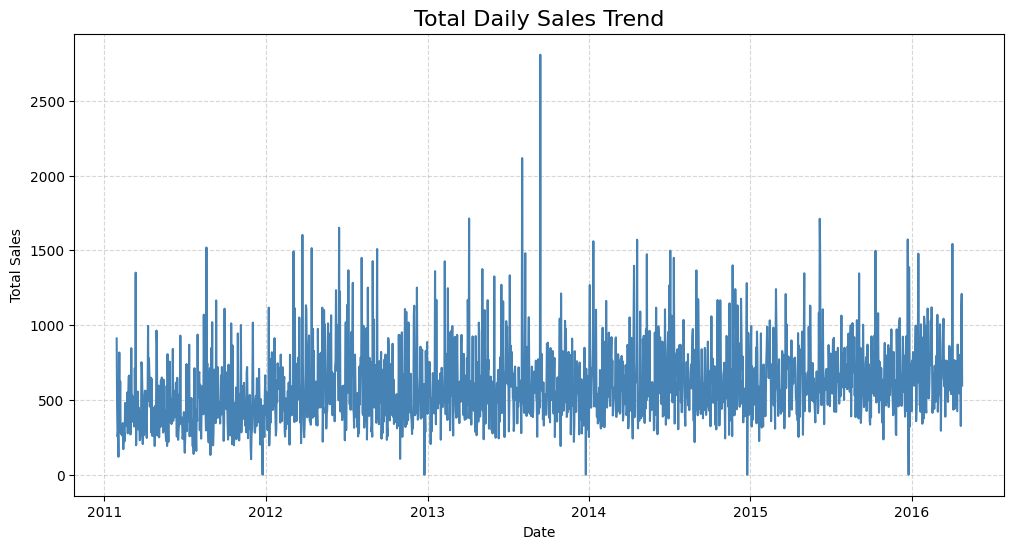

In [54]:
"""how total daily sales vary by date.(line plot) """

#Group by date and sum Sales
daily_sales = df_sample.groupby("date")["sales"].sum().reset_index()
#to datetime type so matplotlib can handle it properly
daily_sales['date']=pd.to_datetime(daily_sales["date"])

daily_sales =daily_sales.sort_values("date")

plt.figure(figsize=(12,6))
plt.plot(daily_sales["date"] , daily_sales["sales"] , color="steelblue")

plt.title("Total Daily Sales Trend", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.grid(True, linestyle="--", alpha=0.5)


/tmp/ipython-input-3149062693.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cat_sales = df_sample.groupby("cat_id")["sales"].sum().reset_index()


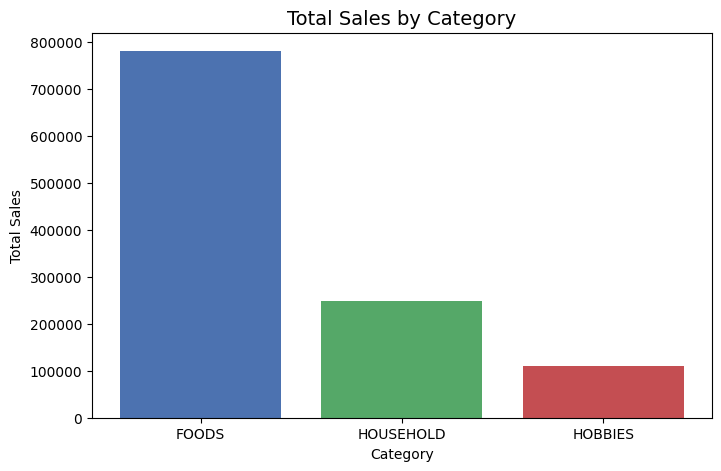

In [55]:
# Group by category and sum total sales
cat_sales = df_sample.groupby("cat_id")["sales"].sum().reset_index()

# Sort descending
cat_sales = cat_sales.sort_values("sales", ascending=False)


# Plot
plt.figure(figsize=(8,5))
plt.bar(cat_sales["cat_id"], cat_sales["sales"], color=["#4C72B0", "#55A868", "#C44E52"])
plt.title("Total Sales by Category", fontsize=14)
plt.xlabel("Category")
plt.ylabel("Total Sales")
plt.show()


Total stores: 10
Number of stores per state:
state_id
CA    4
TX    3
WI    3
Name: store_id, dtype: int64


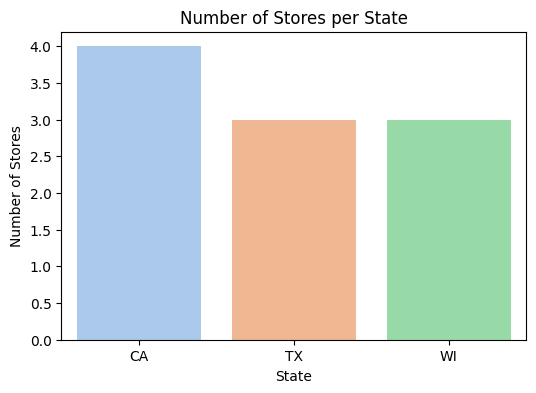

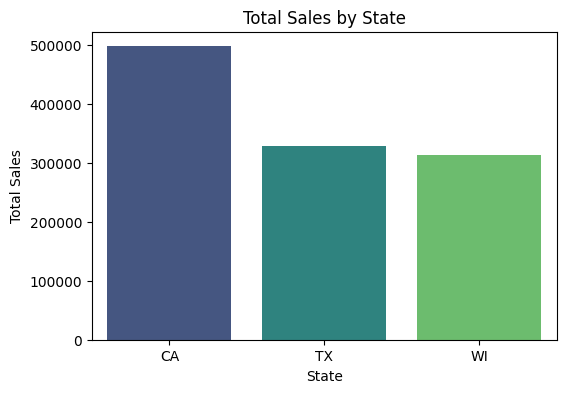

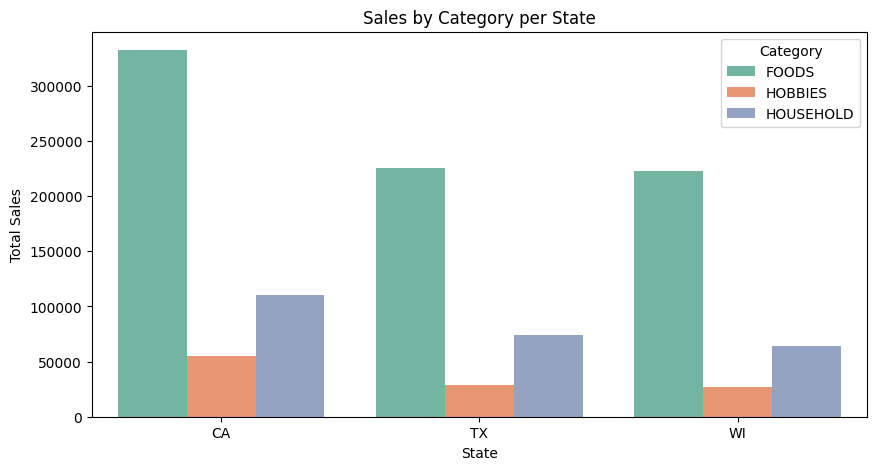

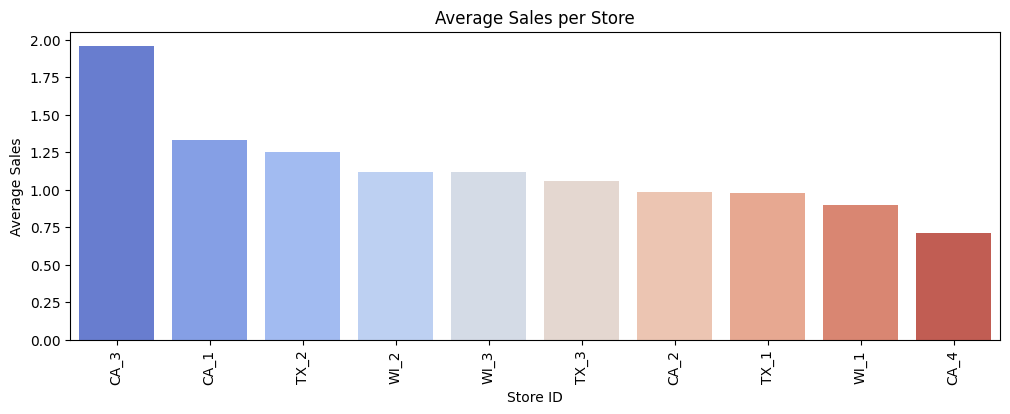

In [ ]:
# ===============================
# 1. عدد المتاجر الكلي وعدد المتاجر لكل ولاية
# ===============================
total_stores = df_sample['store_id'].nunique()
print(f"Total stores: {total_stores}")

stores_per_state = df_sample.groupby('state_id')['store_id'].nunique()
print("Number of stores per state:")
print(stores_per_state)

# Bar plot: عدد المتاجر لكل ولاية
plt.figure(figsize=(6,4))
sns.barplot(x=stores_per_state.index, y=stores_per_state.values, palette="pastel")
plt.title("Number of Stores per State")
plt.ylabel("Number of Stores")
plt.xlabel("State")
plt.show()

# ===============================
# 2. توزيع المبيعات لكل ولاية
# ===============================
sales_by_state = df_sample.groupby('state_id')['sales'].sum()
plt.figure(figsize=(6,4))
sns.barplot(x=sales_by_state.index, y=sales_by_state.values, palette="viridis")
plt.title("Total Sales by State")
plt.ylabel("Total Sales")
plt.xlabel("State")
plt.show()

# ===============================
# 3. توزيع المبيعات لكل category داخل كل ولاية
# ===============================
sales_by_state_cat = df_sample.groupby(['state_id','cat_id'])['sales'].sum().reset_index()
plt.figure(figsize=(10,5))
sns.barplot(x='state_id', y='sales', hue='cat_id', data=sales_by_state_cat, palette="Set2")
plt.title("Sales by Category per State")
plt.ylabel("Total Sales")
plt.xlabel("State")
plt.legend(title="Category")
plt.show()

# ===============================
# 4. متوسط المبيعات لكل متجر
# ===============================
avg_sales_per_store = df_sample.groupby('store_id')['sales'].mean().sort_values(ascending=False)
plt.figure(figsize=(12,4))
sns.barplot(x=avg_sales_per_store.index, y=avg_sales_per_store.values, palette="coolwarm")
plt.title("Average Sales per Store")
plt.ylabel("Average Sales")
plt.xlabel("Store ID")
plt.xticks(rotation=90)
plt.show()


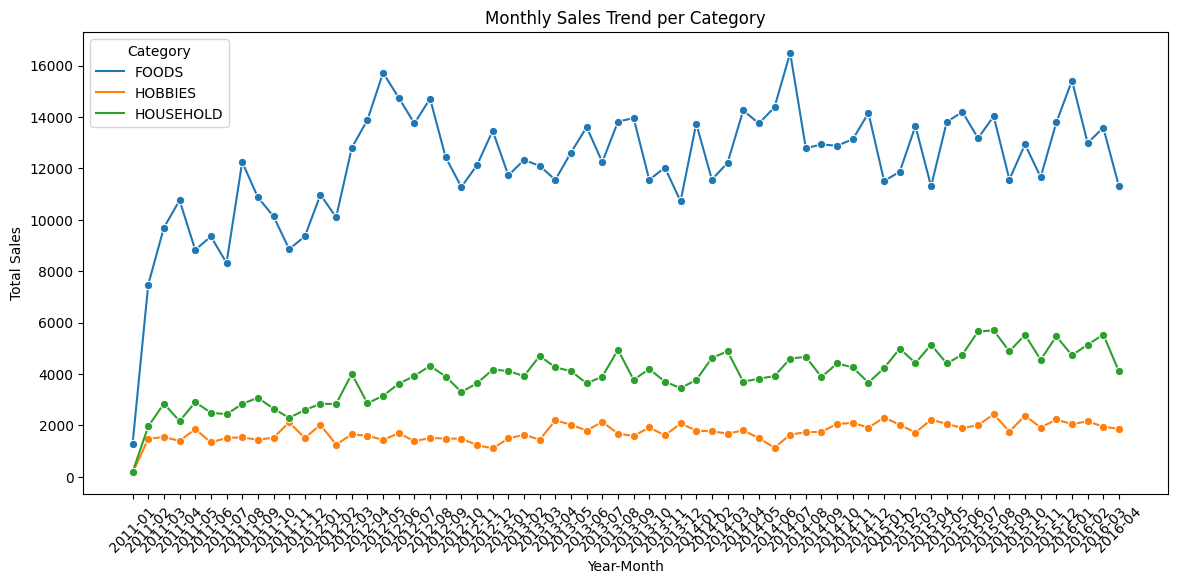

In [ ]:
# ===============================
# 5. تحويل العمود date لتاريخ datetime
# ===============================
df_sample['date'] = pd.to_datetime(df_sample['date'])

# ===============================
# 6. إنشاء عمود للشهر والسنة
# ===============================
df_sample['year_month'] = df_sample['date'].dt.to_period('M')

# ===============================
# 7. حساب مجموع المبيعات لكل category لكل شهر
# ===============================
monthly_sales = df_sample.groupby(['year_month', 'cat_id'])['sales'].sum().reset_index()
monthly_sales['year_month'] = monthly_sales['year_month'].astype(str)

# ===============================
# 8. رسم الخطوط لكل category
# ===============================
plt.figure(figsize=(14,6))
sns.lineplot(x='year_month', y='sales', hue='cat_id', data=monthly_sales, marker='o')
plt.xticks(rotation=45)
plt.title("Monthly Sales Trend per Category")
plt.xlabel("Year-Month")
plt.ylabel("Total Sales")
plt.legend(title="Category")
plt.show()

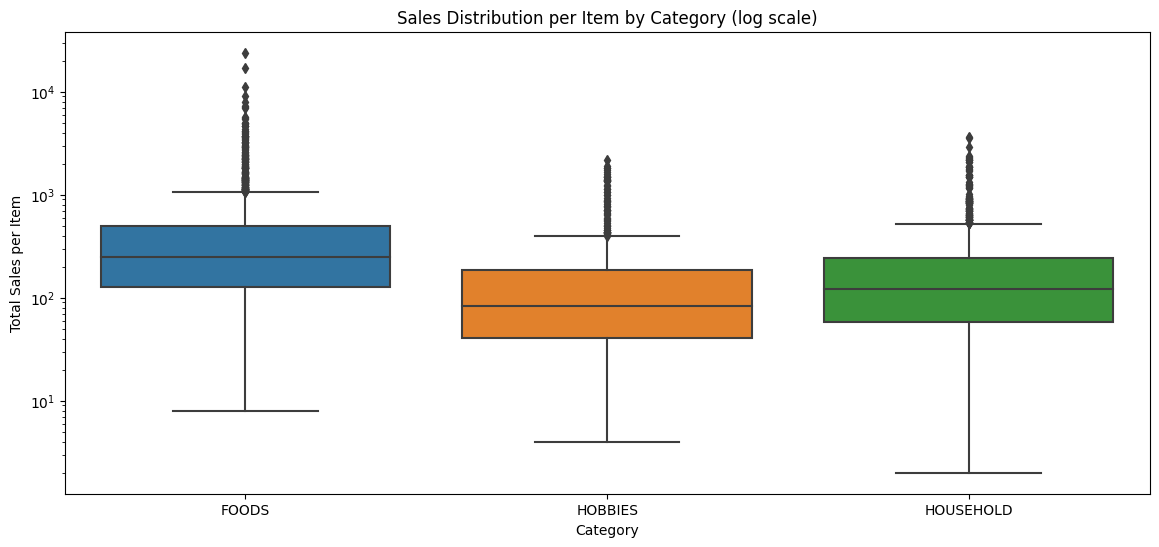

In [ ]:
# ===============================
# 9. حساب مجموع المبيعات لكل item
# ===============================
item_sales = df_sample.groupby(['cat_id', 'item_id'])['sales'].sum().reset_index()

# ===============================
# 10. رسم توزيع المبيعات لكل category
# ===============================
plt.figure(figsize=(14,6))
sns.boxplot(x='cat_id', y='sales', data=item_sales)
plt.yscale('log')  # عشان الفروقات الكبيرة بين المنتجات تظهر بشكل أفضل
plt.title("Sales Distribution per Item by Category (log scale)")
plt.xlabel("Category")
plt.ylabel("Total Sales per Item")
plt.show()


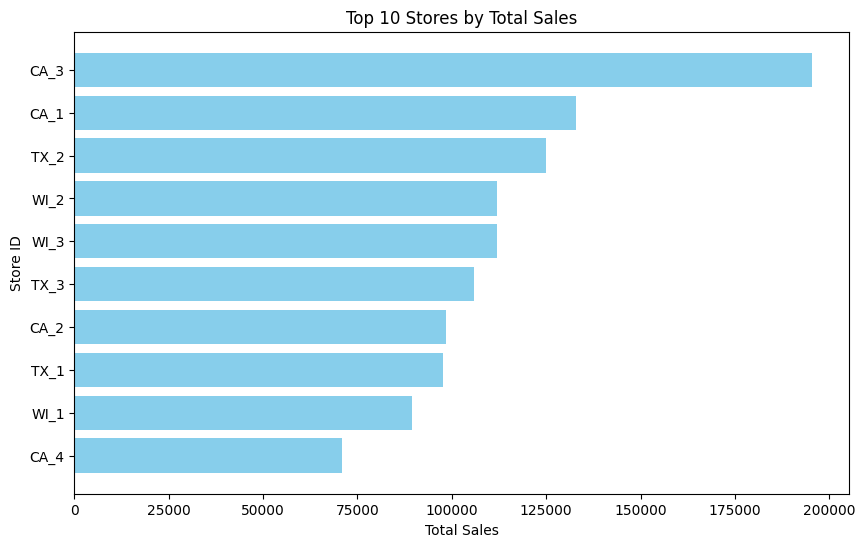

In [ ]:
# Top 10 stores by total sales
top_stores = df_sample.groupby("store_id")["sales"].sum().sort_values(ascending=False).head(10).reset_index()

plt.figure(figsize=(10,6))
plt.barh(top_stores["store_id"], top_stores["sales"], color="skyblue")
plt.xlabel("Total Sales")
plt.ylabel("Store ID")
plt.title("Top 10 Stores by Total Sales")
plt.gca().invert_yaxis()
plt.show()


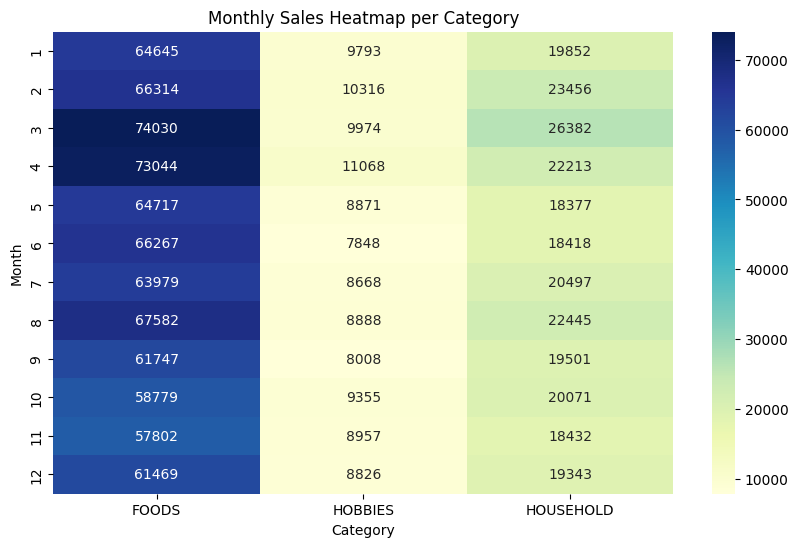

In [ ]:
# Extract month
df_sample["date"] = pd.to_datetime(df_sample["date"])
df_sample["month"] = df_sample["date"].dt.month

# Group by month and category
monthly_category_sales = df_sample.groupby(["month", "cat_id"])["sales"].sum().unstack()

plt.figure(figsize=(10,6))
sns.heatmap(monthly_category_sales, cmap="YlGnBu", annot=True, fmt=".0f")
plt.title("Monthly Sales Heatmap per Category")
plt.xlabel("Category")
plt.ylabel("Month")
plt.show()


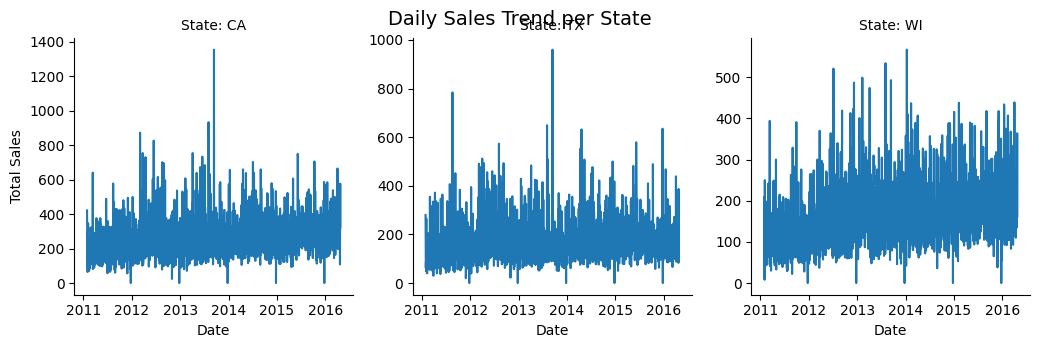

In [ ]:
daily_sales_state = df_sample.groupby(["date", "state_id"])["sales"].sum().reset_index()

# Create line plots for each state
g = sns.FacetGrid(daily_sales_state, col="state_id", col_wrap=3, height=3.5, sharey=False)
g.map(sns.lineplot, "date", "sales")
g.set_titles("State: {col_name}")
g.set_axis_labels("Date", "Total Sales")
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Daily Sales Trend per State", fontsize=14)
plt.show()


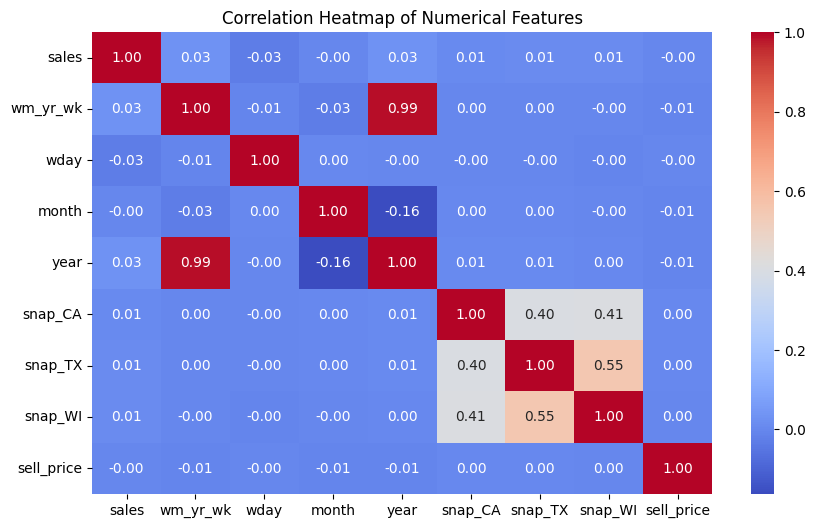

In [ ]:
# Select only numeric columns
numeric_cols = df_sample.select_dtypes(include='number')

# Correlation matrix
corr = numeric_cols.corr()

plt.figure(figsize=(10,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Numerical Features")
plt.show()


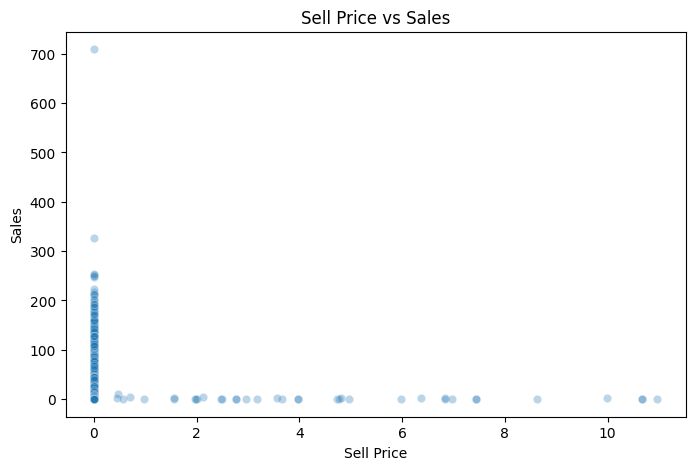

In [ ]:
# Filter out rows with missing prices
df_price = df_sample.dropna(subset=['sell_price'])

plt.figure(figsize=(8,5))
sns.scatterplot(data=df_price, x='sell_price', y='sales', alpha=0.3)
plt.title("Sell Price vs Sales")
plt.xlabel("Sell Price")
plt.ylabel("Sales")
plt.show()


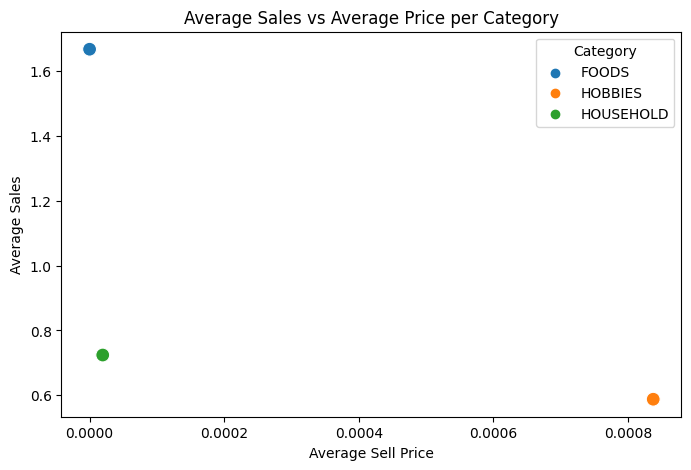

In [ ]:
avg_sales_price = df_price.groupby("cat_id")[["sell_price", "sales"]].mean().reset_index()

plt.figure(figsize=(8,5))
sns.scatterplot(data=avg_sales_price, x="sell_price", y="sales", hue="cat_id", s=100)
plt.title("Average Sales vs Average Price per Category")
plt.xlabel("Average Sell Price")
plt.ylabel("Average Sales")
plt.legend(title="Category")
plt.show()


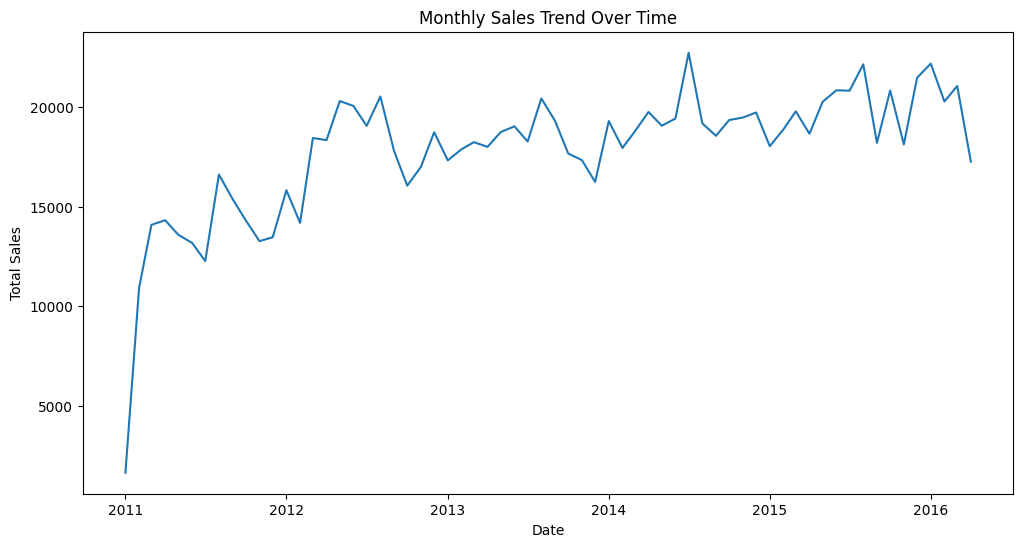

In [ ]:
monthly_sales = df_sample.groupby(["year", "month"])["sales"].sum().reset_index()
monthly_sales["date"] = pd.to_datetime(monthly_sales["year"].astype(str) + "-" + monthly_sales["month"].astype(str) + "-01")

plt.figure(figsize=(12,6))
sns.lineplot(data=monthly_sales, x="date", y="sales")
plt.title("Monthly Sales Trend Over Time")
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.show()


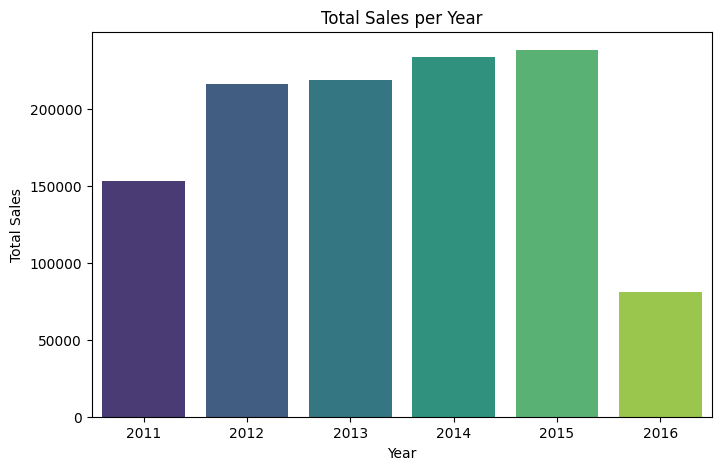

In [ ]:
yearly_sales = df_sample.groupby("year")["sales"].sum().reset_index()

plt.figure(figsize=(8,5))
sns.barplot(data=yearly_sales, x="year", y="sales", palette="viridis")
plt.title("Total Sales per Year")
plt.xlabel("Year")
plt.ylabel("Total Sales")
plt.show()


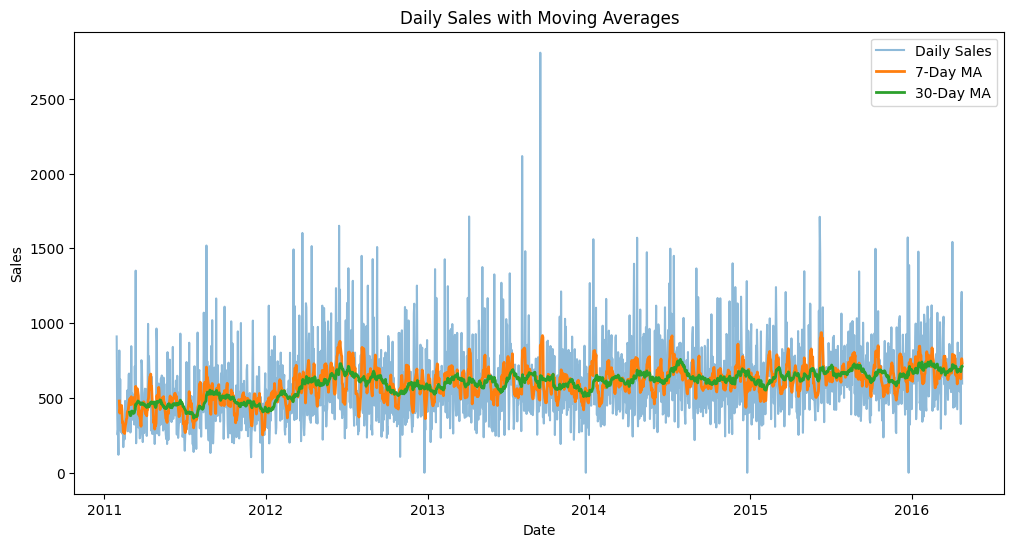

In [ ]:
# Group by date and calculate total daily sales
daily_sales = df_sample.groupby("date")["sales"].sum().reset_index()

# Sort by date to ensure correct order
daily_sales = daily_sales.sort_values("date")

# Compute 7-day and 30-day moving averages
daily_sales["7d_ma"] = daily_sales["sales"].rolling(window=7).mean()
daily_sales["30d_ma"] = daily_sales["sales"].rolling(window=30).mean()

# Plot
plt.figure(figsize=(12,6))
plt.plot(daily_sales["date"], daily_sales["sales"], label="Daily Sales", alpha=0.5)
plt.plot(daily_sales["date"], daily_sales["7d_ma"], label="7-Day MA", linewidth=2)
plt.plot(daily_sales["date"], daily_sales["30d_ma"], label="30-Day MA", linewidth=2)
plt.title("Daily Sales with Moving Averages")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()


Feature Engineering

In [12]:
import pandas as pd

# Ensure date column is datetime
df_sample['date'] = pd.to_datetime(df_sample['date'])

# Extract useful time features
df_sample['day_of_week'] = df_sample['date'].dt.dayofweek      # Monday=0, Sunday=6
df_sample['is_weekend'] = df_sample['day_of_week'].isin([5, 6]).astype(int)
df_sample['quarter'] = df_sample['date'].dt.quarter
df_sample['day_of_year'] = df_sample['date'].dt.dayofyear

# Check result
df_sample[['date', 'day_of_week', 'is_weekend', 'month', 'quarter', 'year', 'day_of_year']].head()


,date,day_of_week,is_weekend,month,quarter,year,day_of_year
0,2012-10-04,3,0,10,4,2012,278
1,2011-09-29,3,0,9,3,2011,272
2,2015-03-09,0,0,3,1,2015,68
3,2014-12-23,1,0,12,4,2014,357
4,2016-02-16,1,0,2,1,2016,47


c:\Users\Alaa\miniconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  This is separate from the ipykernel package so we can avoid doing imports until


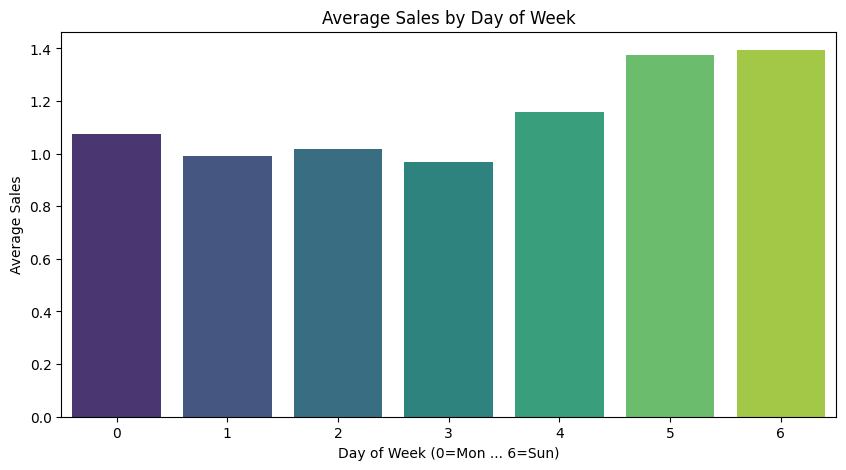

c:\Users\Alaa\miniconda3\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  # This is added back by InteractiveShellApp.init_path()


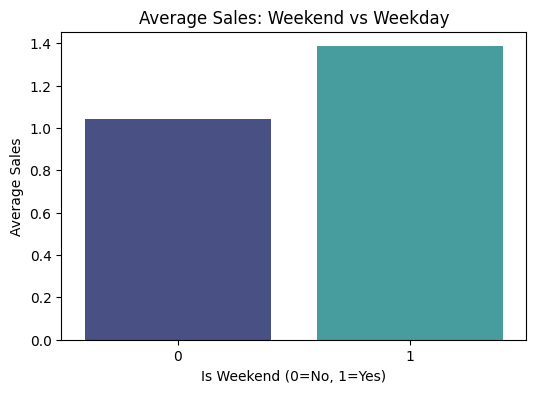

In [ ]:

# 1️⃣ Average sales by day of week
plt.figure(figsize=(10, 5))
sns.barplot(x='day_of_week', y='sales', data=df_sample, estimator='mean', ci=None, palette='viridis')
plt.title('Average Sales by Day of Week')
plt.xlabel('Day of Week (0=Mon ... 6=Sun)')
plt.ylabel('Average Sales')
plt.show()

# 2️⃣ Average sales on weekends vs weekdays
plt.figure(figsize=(6, 4))
sns.barplot(x='is_weekend', y='sales', data=df_sample, estimator='mean', ci=None, palette='mako')
plt.title('Average Sales: Weekend vs Weekday')
plt.xlabel('Is Weekend (0=No, 1=Yes)')
plt.ylabel('Average Sales')
plt.show()


c:\Users\Alaa\miniconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  if __name__ == "__main__":


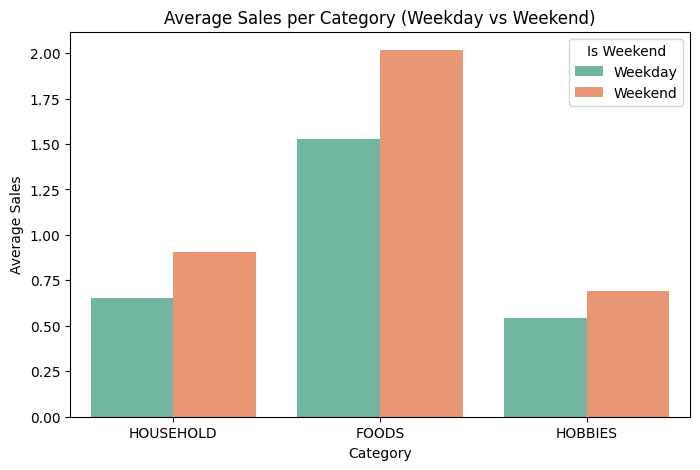

In [ ]:
plt.figure(figsize=(8, 5))
sns.barplot(
    data=df_sample,
    x='cat_id',
    y='sales',
    hue='is_weekend',
    estimator='mean',
    ci=None,
    palette='Set2'
)

plt.title('Average Sales per Category (Weekday vs Weekend)')
plt.xlabel('Category')
plt.ylabel('Average Sales')
plt.legend(title='Is Weekend', labels=['Weekday', 'Weekend'])
plt.show()


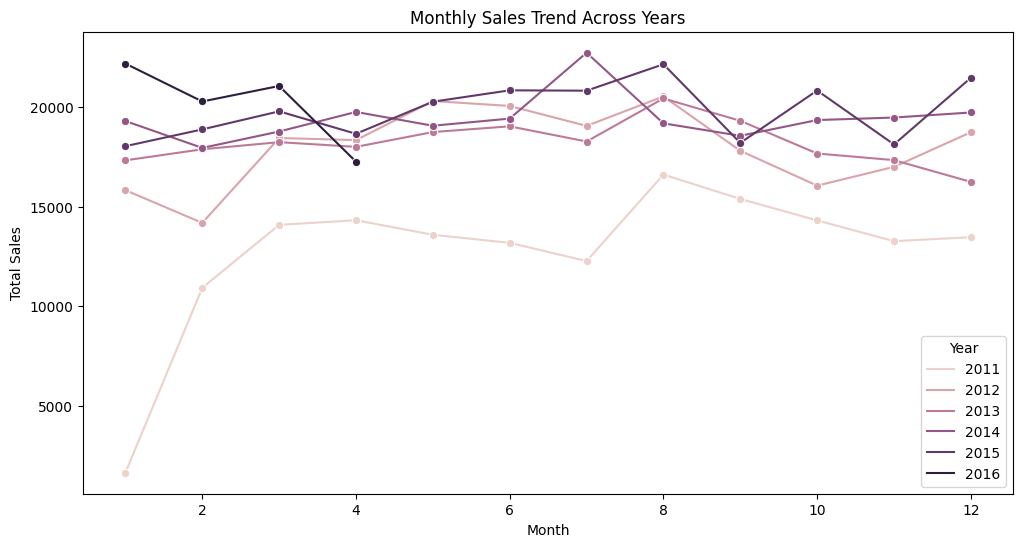

In [ ]:
monthly_sales = (
    df_sample.groupby(['year', 'month'])['sales']
    .sum()
    .reset_index()
)

plt.figure(figsize=(12, 6))
sns.lineplot(
    data=monthly_sales,
    x='month',
    y='sales',
    hue='year',
    marker='o'
)
plt.title('Monthly Sales Trend Across Years')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.legend(title='Year')
plt.show()


Modeling

In [13]:
# Convert date column to datetime if not already
df_sample['date'] = pd.to_datetime(df_sample['date'])

# Extract date parts
df_sample['year'] = df_sample['date'].dt.year
df_sample['month'] = df_sample['date'].dt.month
df_sample['day'] = df_sample['date'].dt.day
df_sample['weekday'] = df_sample['date'].dt.weekday  # 0=Mon, 6=Sun
df_sample['weekofyear'] = df_sample['date'].dt.isocalendar().week.astype(int)
df_sample['is_weekend'] = df_sample['weekday'].isin([5, 6]).astype(int)


In [14]:
cat_features = ['store_id', 'state_id', 'cat_id']

for col in cat_features:
    df_sample[col] = df_sample[col].astype('category')


In [15]:
# Sort by store and date
df_sample = df_sample.sort_values(['store_id', 'date'])

# Create lag features for 1, 7, and 30 days
df_sample['lag_1'] = df_sample.groupby('store_id')['sales'].shift(1)
df_sample['lag_7'] = df_sample.groupby('store_id')['sales'].shift(7)
df_sample['lag_30'] = df_sample.groupby('store_id')['sales'].shift(30)


/tmp/ipython-input-4018436340.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_sample['lag_1'] = df_sample.groupby('store_id')['sales'].shift(1)
/tmp/ipython-input-4018436340.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_sample['lag_7'] = df_sample.groupby('store_id')['sales'].shift(7)
/tmp/ipython-input-4018436340.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_sample['lag_30'] = df_sample.groupby(

In [16]:
df_sample['rolling_mean_7'] = (
    df_sample.groupby('store_id')['sales'].shift(1).rolling(7).mean()
)

df_sample['rolling_mean_30'] = (
    df_sample.groupby('store_id')['sales'].shift(1).rolling(30).mean()
)


/tmp/ipython-input-219231744.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_sample.groupby('store_id')['sales'].shift(1).rolling(7).mean()
/tmp/ipython-input-219231744.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_sample.groupby('store_id')['sales'].shift(1).rolling(30).mean()


In [17]:
# Total sales per category
category_sales = df_sample.groupby('cat_id')['sales'].transform('sum')
df_sample['total_sales_per_category'] = category_sales

# Total sales per state
state_sales = df_sample.groupby('state_id')['sales'].transform('sum')
df_sample['total_sales_per_state'] = state_sales

# Total sales per store
store_sales = df_sample.groupby('store_id')['sales'].transform('sum')
df_sample['total_sales_per_store'] = store_sales


/tmp/ipython-input-897164613.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  category_sales = df_sample.groupby('cat_id')['sales'].transform('sum')
/tmp/ipython-input-897164613.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  state_sales = df_sample.groupby('state_id')['sales'].transform('sum')
/tmp/ipython-input-897164613.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  store_sales = df_sample.groupby('store_

In [18]:
# Sort by date to keep chronological order
df_sample = df_sample.sort_values('date')

# Define cutoff date for validation (e.g., last 30 days)
cutoff_date = df_sample['date'].max() - pd.Timedelta(days=30)

train = df_sample[df_sample['date'] <= cutoff_date]
valid = df_sample[df_sample['date'] > cutoff_date]

print(train.shape, valid.shape)


(984080, 36) (15920, 36)


In [19]:
train.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,...,day,weekofyear,lag_1,lag_7,lag_30,rolling_mean_7,rolling_mean_30,total_sales_per_category,total_sales_per_state,total_sales_per_store
301076,FOODS_2_134_CA_1_validation,FOODS_2_134,FOODS_2,FOODS,CA_1,CA,d_1,1,2011-01-29,11101,...,29,4,NaN,NaN,NaN,NaN,NaN,780375,497826,132906
89113,HOUSEHOLD_1_097_WI_1_validation,HOUSEHOLD_1_097,HOUSEHOLD_1,HOUSEHOLD,WI_1,WI,d_1,3,2011-01-29,11101,...,29,4,0.0,0.0,0.0,0.000000,0.766667,248987,313580,89579
89934,FOODS_3_621_WI_1_validation,FOODS_3_621,FOODS_3,FOODS,WI_1,WI,d_1,0,2011-01-29,11101,...,29,4,3.0,0.0,0.0,0.428571,0.866667,780375,313580,89579
90218,HOUSEHOLD_1_522_WI_1_validation,HOUSEHOLD_1_522,HOUSEHOLD_1,HOUSEHOLD,WI_1,WI,d_1,1,2011-01-29,11101,...,29,4,0.0,0.0,3.0,0.428571,0.866667,248987,313580,89579
93619,FOODS_2_354_WI_1_validation,FOODS_2_354,FOODS_2,FOODS,WI_1,WI,d_1,0,2011-01-29,11101,...,29,4,1.0,0.0,0.0,0.571429,0.800000,780375,313580,89579


In [20]:
target = 'sales'

# Drop irrelevant columns
drop_cols = ['id', 'date', 'sales']

features = [col for col in df_sample.columns if col not in drop_cols]

In [24]:
features

['item_id',
 'dept_id',
 'cat_id',
 'store_id',
 'state_id',
 'd',
 'wm_yr_wk',
 'weekday',
 'wday',
 'month',
 'year',
 'event_name_1',
 'event_type_1',
 'event_name_2',
 'event_type_2',
 'snap_CA',
 'snap_TX',
 'snap_WI',
 'sell_price',
 'day_of_week',
 'is_weekend',
 'quarter',
 'day_of_year',
 'day',
 'weekofyear',
 'lag_1',
 'lag_7',
 'lag_30',
 'rolling_mean_7',
 'rolling_mean_30',
 'total_sales_per_category',
 'total_sales_per_state',
 'total_sales_per_store']

In [27]:
df_sample[features].head()

,item_id,dept_id,cat_id,store_id,state_id,d,wm_yr_wk,weekday,wday,month,...,day,weekofyear,lag_1,lag_7,lag_30,rolling_mean_7,rolling_mean_30,total_sales_per_category,total_sales_per_state,total_sales_per_store
301076,FOODS_2_134,FOODS_2,FOODS,CA_1,CA,d_1,11101,5,1,1,...,29,4,NaN,NaN,NaN,NaN,NaN,780375,497826,132906
89113,HOUSEHOLD_1_097,HOUSEHOLD_1,HOUSEHOLD,WI_1,WI,d_1,11101,5,1,1,...,29,4,0.0,0.0,0.0,0.000000,0.766667,248987,313580,89579
89934,FOODS_3_621,FOODS_3,FOODS,WI_1,WI,d_1,11101,5,1,1,...,29,4,3.0,0.0,0.0,0.428571,0.866667,780375,313580,89579
90218,HOUSEHOLD_1_522,HOUSEHOLD_1,HOUSEHOLD,WI_1,WI,d_1,11101,5,1,1,...,29,4,0.0,0.0,3.0,0.428571,0.866667,248987,313580,89579
93619,FOODS_2_354,FOODS_2,FOODS,WI_1,WI,d_1,11101,5,1,1,...,29,4,1.0,0.0,0.0,0.571429,0.800000,780375,313580,89579


In [22]:
df_sample.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,...,day,weekofyear,lag_1,lag_7,lag_30,rolling_mean_7,rolling_mean_30,total_sales_per_category,total_sales_per_state,total_sales_per_store
301076,FOODS_2_134_CA_1_validation,FOODS_2_134,FOODS_2,FOODS,CA_1,CA,d_1,1,2011-01-29,11101,...,29,4,NaN,NaN,NaN,NaN,NaN,780375,497826,132906
89113,HOUSEHOLD_1_097_WI_1_validation,HOUSEHOLD_1_097,HOUSEHOLD_1,HOUSEHOLD,WI_1,WI,d_1,3,2011-01-29,11101,...,29,4,0.0,0.0,0.0,0.000000,0.766667,248987,313580,89579
89934,FOODS_3_621_WI_1_validation,FOODS_3_621,FOODS_3,FOODS,WI_1,WI,d_1,0,2011-01-29,11101,...,29,4,3.0,0.0,0.0,0.428571,0.866667,780375,313580,89579
90218,HOUSEHOLD_1_522_WI_1_validation,HOUSEHOLD_1_522,HOUSEHOLD_1,HOUSEHOLD,WI_1,WI,d_1,1,2011-01-29,11101,...,29,4,0.0,0.0,3.0,0.428571,0.866667,248987,313580,89579
93619,FOODS_2_354_WI_1_validation,FOODS_2_354,FOODS_2,FOODS,WI_1,WI,d_1,0,2011-01-29,11101,...,29,4,1.0,0.0,0.0,0.571429,0.800000,780375,313580,89579


In [ ]:
!pip install lightgbm

In [30]:
import lightgbm as lgb

train_data = lgb.Dataset(train[features], label=train['sales'])
valid_data = lgb.Dataset(valid[features], label=valid['sales'])


In [75]:
train[features]

,item_id,dept_id,cat_id,store_id,state_id,d,wm_yr_wk,weekday,wday,month,...,day,weekofyear,lag_1,lag_7,lag_30,rolling_mean_7,rolling_mean_30,total_sales_per_category,total_sales_per_state,total_sales_per_store
301076,FOODS_2_134,FOODS_2,FOODS,CA_1,CA,d_1,11101,5,1,1,...,29,4,NaN,NaN,NaN,NaN,NaN,780375,497826,132906
89113,HOUSEHOLD_1_097,HOUSEHOLD_1,HOUSEHOLD,WI_1,WI,d_1,11101,5,1,1,...,29,4,0.0,0.0,0.0,0.000000,0.766667,248987,313580,89579
89934,FOODS_3_621,FOODS_3,FOODS,WI_1,WI,d_1,11101,5,1,1,...,29,4,3.0,0.0,0.0,0.428571,0.866667,780375,313580,89579
90218,HOUSEHOLD_1_522,HOUSEHOLD_1,HOUSEHOLD,WI_1,WI,d_1,11101,5,1,1,...,29,4,0.0,0.0,3.0,0.428571,0.866667,248987,313580,89579
93619,FOODS_2_354,FOODS_2,FOODS,WI_1,WI,d_1,11101,5,1,1,...,29,4,1.0,0.0,0.0,0.571429,0.800000,780375,313580,89579
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205308,HOUSEHOLD_2_119,HOUSEHOLD_2,HOUSEHOLD,WI_3,WI,d_1883,11608,4,7,3,...,25,12,0.0,0.0,1.0,0.285714,0.733333,248987,313580,111988
214038,HOBBIES_1_218,HOBBIES_1,HOBBIES,WI_3,WI,d_1883,11608,4,7,3,...,25,12,0.0,0.0,0.0,0.285714,0.700000,110572,313580,111988
214556,HOUSEHOLD_2_349,HOUSEHOLD_2,HOUSEHOLD,WI_3,WI,d_1883,11608,4,7,3,...,25,12,0.0,0.0,0.0,0.285714,0.700000,248987,313580,111988
215908,HOUSEHOLD_2_225,HOUSEHOLD_2,HOUSEHOLD,WI_3,WI,d_1883,11608,4,7,3,...,25,12,0.0,0.0,3.0,0.285714,0.700000,248987,313580,111988


In [77]:
train['sales']

,sales
301076,1
89113,3
89934,0
90218,1
93619,0
...,...
205308,0
214038,0
214556,0
215908,2


In [64]:
train[features].info()

<class 'pandas.core.frame.DataFrame'>
Index: 984080 entries, 301076 to 204506
Data columns (total 33 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   item_id                   984080 non-null  category
 1   dept_id                   984080 non-null  category
 2   cat_id                    984080 non-null  category
 3   store_id                  984080 non-null  category
 4   state_id                  984080 non-null  category
 5   d                         984080 non-null  category
 6   wm_yr_wk                  984080 non-null  int64   
 7   weekday                   984080 non-null  int32   
 8   wday                      984080 non-null  int64   
 9   month                     984080 non-null  int32   
 10  year                      984080 non-null  int32   
 11  event_name_1              79850 non-null   category
 12  event_type_1              79850 non-null   category
 13  event_name_2              205

In [79]:
train['sales']

,sales
301076,1
89113,3
89934,0
90218,1
93619,0
...,...
205308,0
214038,0
214556,0
215908,2


In [31]:
params = {
    'objective': 'regression',
    'metric': 'rmse',        # root mean squared error
    'boosting_type': 'gbdt', # gradient boosting
    'learning_rate': 0.05,
    'num_leaves': 31,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1
}


In [32]:
model = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, valid_data],
    num_boost_round=1000,
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=100)
    ]
)



Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 2.64041	valid_1's rmse: 2.58594
[200]	training's rmse: 2.48711	valid_1's rmse: 2.56106
[300]	training's rmse: 2.39399	valid_1's rmse: 2.54508
[400]	training's rmse: 2.32407	valid_1's rmse: 2.54082
[500]	training's rmse: 2.26493	valid_1's rmse: 2.53266
[600]	training's rmse: 2.21751	valid_1's rmse: 2.52429
[700]	training's rmse: 2.1743	valid_1's rmse: 2.51937
Early stopping, best iteration is:
[695]	training's rmse: 2.17637	valid_1's rmse: 2.51876


In [34]:
from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(valid['sales'], y_pred) ** 0.5
print(f"Validation RMSE: {rmse:.4f}")


Validation RMSE: 2.5188


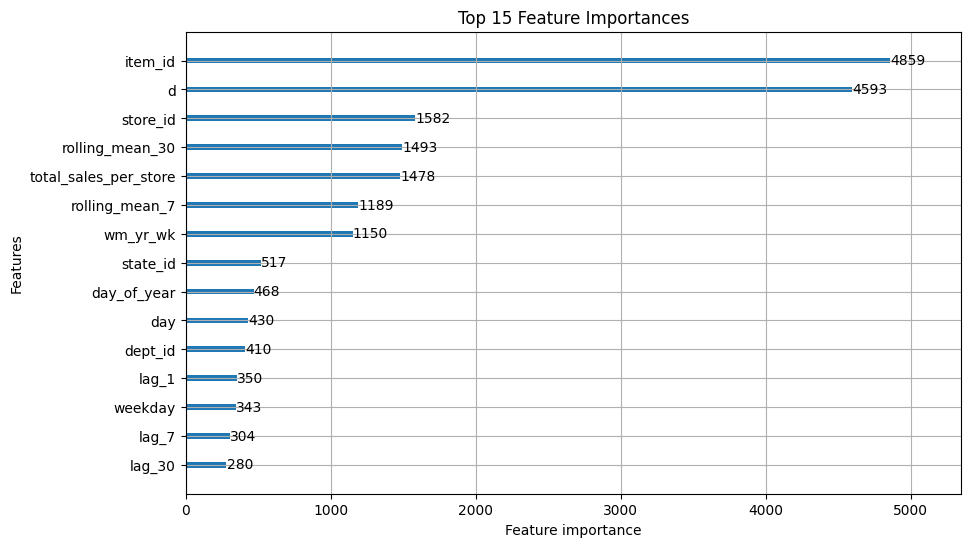

In [35]:
# عرض أهمية الخصائص (features)
lgb.plot_importance(model, max_num_features=15, figsize=(10, 6))
plt.title("Top 15 Feature Importances")
plt.show()


In [36]:
# Make predictions
y_pred = model.predict(valid[features], num_iteration=model.best_iteration)

# Actual values
y_true = valid[target]

In [37]:
y_pred

array([0.27969142, 1.26565777, 4.13523131, ..., 0.64355302, 0.61917037,
       0.62784921])

In [38]:
y_true

,sales
907019,0
907235,3
909866,7
914718,1
88022,0
...,...
905206,0
905772,1
907384,0
910440,2


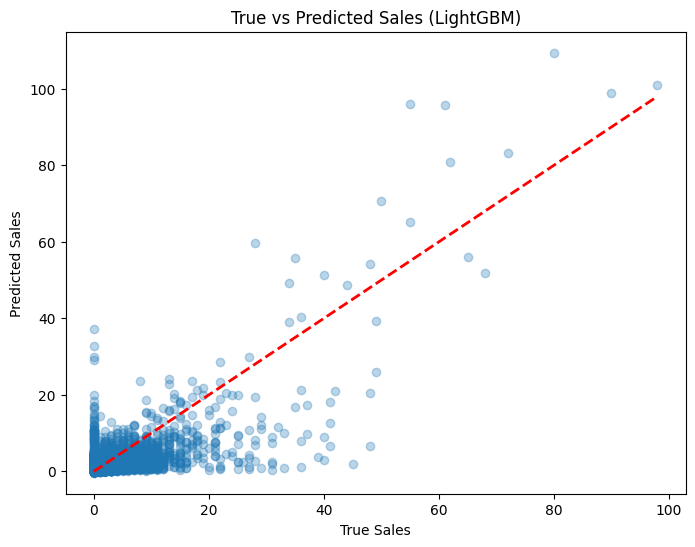

In [39]:
plt.figure(figsize=(8, 6))
plt.scatter(y_true, y_pred, alpha=0.3)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)  # ideal line
plt.xlabel("True Sales")
plt.ylabel("Predicted Sales")
plt.title("True vs Predicted Sales (LightGBM)")
plt.show()


In [42]:
from sklearn.preprocessing import LabelEncoder

# تحويل الأعمدة النصية إلى أرقام بطريقة آمنة
for col in train.columns:
    if train[col].dtype == 'object':
        le = LabelEncoder()
        all_values = pd.concat([train[col], valid[col]], axis=0).astype(str)
        le.fit(all_values)
        train[col] = le.transform(train[col].astype(str))
        valid[col] = le.transform(valid[col].astype(str))


In [44]:
features

['item_id',
 'dept_id',
 'cat_id',
 'store_id',
 'state_id',
 'd',
 'wm_yr_wk',
 'weekday',
 'wday',
 'month',
 'year',
 'event_name_1',
 'event_type_1',
 'event_name_2',
 'event_type_2',
 'snap_CA',
 'snap_TX',
 'snap_WI',
 'sell_price',
 'day_of_week',
 'is_weekend',
 'quarter',
 'day_of_year',
 'day',
 'weekofyear',
 'lag_1',
 'lag_7',
 'lag_30',
 'rolling_mean_7',
 'rolling_mean_30',
 'total_sales_per_category',
 'total_sales_per_state',
 'total_sales_per_store']

In [62]:
train[features].head(1)

,item_id,dept_id,cat_id,store_id,state_id,d,wm_yr_wk,weekday,wday,month,...,day,weekofyear,lag_1,lag_7,lag_30,rolling_mean_7,rolling_mean_30,total_sales_per_category,total_sales_per_state,total_sales_per_store
301076,FOODS_2_134,FOODS_2,FOODS,CA_1,CA,d_1,11101,5,1,1,...,29,4,NaN,NaN,NaN,NaN,NaN,780375,497826,132906


In [47]:
cat_cols = [col for col in features if str(train[col].dtype) == 'category']

for col in cat_cols:
    # Find categories in valid that are not in train
    unseen = set(valid[col].cat.categories) - set(train[col].cat.categories)
    if unseen:
        print(f"Column {col} has unseen categories in valid: {unseen}")


Column d has unseen categories in valid: {'d_1889', 'd_1907', 'd_1895', 'd_1900', 'd_1892', 'd_1887', 'd_1897', 'd_1913', 'd_1906', 'd_1886', 'd_1912', 'd_1899', 'd_1894', 'd_1893', 'd_1896', 'd_1901', 'd_1885', 'd_1903', 'd_1884', 'd_1902', 'd_1891', 'd_1898', 'd_1910', 'd_1904', 'd_1888', 'd_1911', 'd_1905', 'd_1890', 'd_1908', 'd_1909'}


In [48]:
train['d'] = train['d'].astype('category')
valid['d'] = valid['d'].astype('category')

# Align categories: unseen categories in valid become NaN
valid['d'] = valid['d'].cat.set_categories(train['d'].cat.categories)


/tmp/ipython-input-4185549315.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['d'] = train['d'].astype('category')
/tmp/ipython-input-4185549315.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['d'] = valid['d'].astype('category')
/tmp/ipython-input-4185549315.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

In [50]:
import xgboost as xgb

# Identify categorical columns
cat_cols = [col for col in features if str(train[col].dtype) == 'category']

# Convert columns to category and align categories
for col in cat_cols:
    train[col] = train[col].astype('category')
    valid[col] = valid[col].astype('category')
    # Align valid categories with train, unseen values become NaN
    valid[col] = valid[col].cat.set_categories(train[col].cat.categories)

# Optional: check for any NaNs introduced
for col in cat_cols:
    n_nans = valid[col].isna().sum()
    if n_nans > 0:
        print(f"Column {col} has {n_nans} NaNs in valid after alignment")

# Create DMatrix safely
dtrain = xgb.DMatrix(train[features], label=train['sales'], enable_categorical=True)
dvalid = xgb.DMatrix(valid[features], label=valid['sales'], enable_categorical=True)

print("DMatrix created successfully!")


/tmp/ipython-input-815929773.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[col] = train[col].astype('category')
/tmp/ipython-input-815929773.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid[col] = valid[col].astype('category')
/tmp/ipython-input-815929773.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/sta

Column d has 15920 NaNs in valid after alignment
Column event_name_1 has 15330 NaNs in valid after alignment
Column event_type_1 has 15330 NaNs in valid after alignment
Column event_name_2 has 15920 NaNs in valid after alignment
Column event_type_2 has 15920 NaNs in valid after alignment
DMatrix created successfully!


In [52]:
# Define model parameters
params = {
    'objective': 'reg:squarederror',   # Regression task
    'eval_metric': 'rmse',             # Root Mean Squared Error
    'learning_rate': 0.05,
    'max_depth': 8,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}

# Train the model with evaluation
xgb_model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,
    evals=[(dtrain, 'train'), (dvalid, 'valid')],
    early_stopping_rounds=50,
    verbose_eval=100
)

# Predict on validation data
y_pred_xgb = xgb_model.predict(dvalid)

# Evaluate RMSE
from sklearn.metrics import mean_squared_error

rmse_xgb = mean_squared_error(valid['sales'], y_pred_xgb) ** 0.5
print(f"✅ XGBoost Validation RMSE: {rmse_xgb:.4f}")



[0]	train-rmse:3.89670	valid-rmse:3.51941
[100]	train-rmse:2.03158	valid-rmse:2.65090
[200]	train-rmse:1.83204	valid-rmse:2.61562
[300]	train-rmse:1.69305	valid-rmse:2.61359
[400]	train-rmse:1.58975	valid-rmse:2.60161
[500]	train-rmse:1.51214	valid-rmse:2.59825
[600]	train-rmse:1.45232	valid-rmse:2.59443
[700]	train-rmse:1.40369	valid-rmse:2.59091
[800]	train-rmse:1.36137	valid-rmse:2.58757
[900]	train-rmse:1.32221	valid-rmse:2.58605
[999]	train-rmse:1.28714	valid-rmse:2.58220
✅ XGBoost Validation RMSE: 2.5822


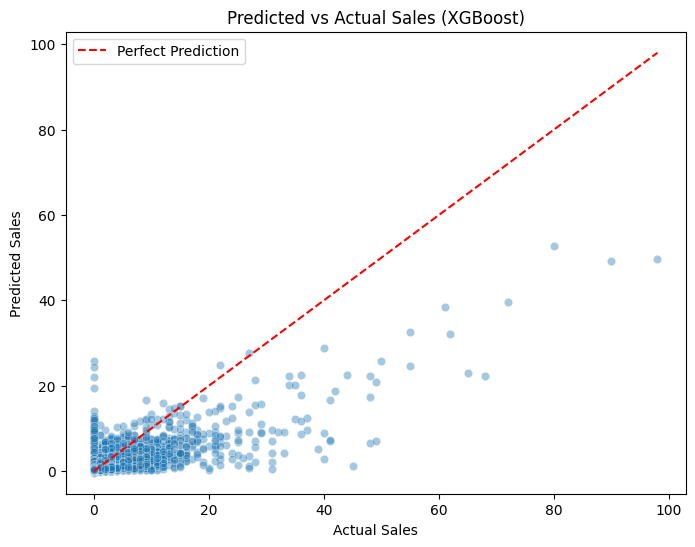

In [53]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_true, y=y_pred_xgb, alpha=0.4)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', label='Perfect Prediction')
plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
plt.title("Predicted vs Actual Sales (XGBoost)")
plt.legend()
plt.show()


In [58]:
# ------------------------------
# 7. Compare Models & Save Best ML Model
# ------------------------------
from sklearn.metrics import mean_squared_error
import joblib

# ------------------------------
# 1. Compute RMSE for both models
# ------------------------------
y_pred_xgb = xgb_model.predict(dvalid)  # XGBoost predictions
y_pred_lgb = model.predict(valid[features])  # LightGBM predictions

rmse_xgb = mean_squared_error(valid['sales'], y_pred_xgb) ** 0.5
rmse_lgb = mean_squared_error(valid['sales'], y_pred_lgb) ** 0.5

print(f"XGBoost RMSE: {rmse_xgb:.4f}")
print(f"LightGBM RMSE: {rmse_lgb:.4f}")

# ------------------------------
# 2. Compare & Save Best Model
# ------------------------------
rmse_results = {
    'XGBoost': rmse_xgb,
    'LightGBM': rmse_lgb
}

best_model_name = min(rmse_results, key=rmse_results.get)
print(f"\nBest Model Based on RMSE: {best_model_name}")

# Save the best model as .pkl
if best_model_name == 'XGBoost':
    joblib.dump(xgb_model, 'best_sales_model_xgb.pkl')
    print("✅ Best model saved: best_sales_model_xgb.pkl")
else:
    joblib.dump(model, 'best_sales_model_lgb.pkl')
    print("✅ Best model saved: best_sales_model_lgb.pkl")


XGBoost RMSE: 2.5822
LightGBM RMSE: 2.5188

Best Model Based on RMSE: LightGBM
✅ Best model saved: best_sales_model_lgb.pkl
